# Introduction

DICOM mammogram images are commonly encoded with pixel depths ranging from 8 to 16 bits, providing a broad spectrum of approximately 256 to 65,536 shades of gray. However, in the context of training deep neural networks standardization is paramount. To ensure uniformity and compatibility across all mammographic data, it is essential to convert these images to an 8-bit format. This guide outlines the steps to convert DICOM mammograms from their original 8–16 bit depth to an 8-bit format, addressing the imperative need for standardization in the training of deep neural networks for mammographic data.

# Working with DICOM LUT

## Modality LUT
A Modality LUT serves to convert pixel values that are dependent on the equipment manufacturer into values that are independent of the manufacturer, such as converting them into standardized units like Hounsfield units for CT images.
Linear transformations are described using the "Rescale Slope" (0028,1053) and "Rescale Intercept" (0028,1052) elements: pixel value*Rescale Slope+Rescale Intercept.
Non-linear transformations are specified using the "Modality LUT Sequence" (0028,3000) element.

## VOI LUT
A VOI LUT allows the transformation of the modality pixel values into pixel values that are meaningful for print or display. This transformation is applied after any "Modality LUT". "Window Center" (0028,1050) and "Window Width" (0028,1051) are used to describe the transformation when it is linear, while the "VOI LUT Sequence" (0028,3010) is used to describe non-linear transformations.

To see how output values are calculated from input values refer to [VOI LUT](https://dicom.innolitics.com/ciods/cr-image/voi-lut)


# Install dependencies

Python has a library called pydicom which is is a pure python package for parsing DICOM files.

https://pypi.org/project/pydicom/0.9.7/

In [9]:
!pip install pydicom
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_modality_lut
import matplotlib.pyplot as plt

# Utility Functions

In [7]:
def min_max_scale(img):
    maxv = img.max()
    minv = img.min()
    if maxv > minv:
        return (img - minv) / (maxv - minv)
    else:
        return img - minv  # ==0

def preprocess_dicom(arr, ds):
    """
    Function applies the following:
    Rescale with Modality LUT or slope and intercept
    VOI or Windowing
    Fix the photometric interpretation
    Normalize between 0 and 255: convert to 8-bits pixel values

    Parameters
    ----------
    arr : numpy.ndarray
    ds : dataset.Dataset

    Returns
    -------
    numpy.ndarray
        An array with applied multiple grayscale transformations
    """
    arr = apply_modality_lut(arr, ds)
    arr = arr.astype(np.uint16)
    arr = apply_voi_lut(arr, ds, index=0)
    if ds.BitsAllocated != 8:
        arr = min_max_scale(arr)
        arr = arr * 255

    arr = arr.astype(np.uint8)
    if ds.PhotometricInterpretation == 'MONOCHROME1':
        arr = 255 - arr

    return arr

# Preprocess Raw Pixel Data

In [8]:
ds = pydicom.dcmread('/content/IMG-0004-00001.dicom')
arr = ds.pixel_array
out_1 = preprocess_dicom(arr, ds)
out_2 = min_max_scale(arr)

Text(0.5, 1.0, 'Simple Min-Max Scaling')

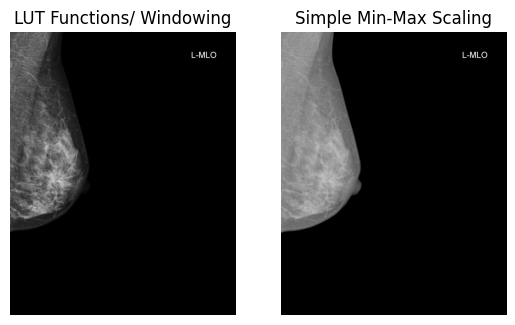

In [23]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(out_1, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f'LUT Functions/ Windowing')
ax[1].imshow(out_2, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'Simple Min-Max Scaling')

Observe that the image on the left appears less "washed out," exhibiting enhanced contrast between soft and dense tissues.